根据题目的要求，本内容的目的是通过利用信用卡交易历史数据来构建简单的反欺诈消费模型，以减少用户的损失。

首先，对数据集的标签进行初步分析。

Class
0    284315
1       492
Name: count, dtype: int64


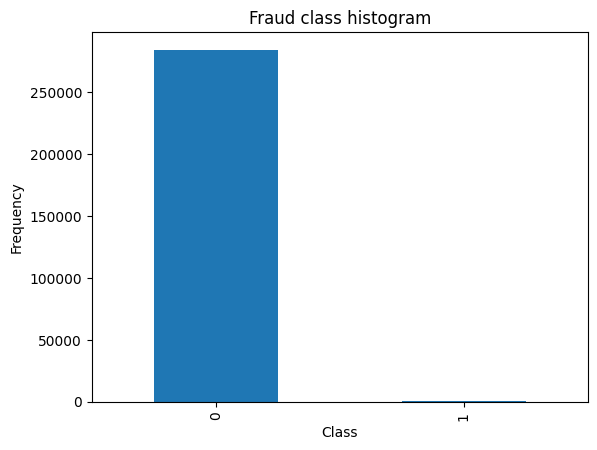

In [23]:
import modin.pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv("creditcard.csv")
count_classes = pd.value_counts(data["Class"], sort=True)
print(count_classes)
count_classes.plot(kind="bar")
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

根据输出结果，我们不难发现如下两个特点：

1. 标签仅有两个类别
2. 正样本占比极低

所以该问题是一个不平衡的二分类问题，在建立模型前，需要对数据进行一定的处理，避免因正样本比重太低而产生的模型准确率较差的问题。

在本例中，我们采取的方法是下采样，即在占比较多的数据中只抽取一部分内容，使得新数据集中两种类别的数据比重相同。

在处理完数据不平衡的问题之后，我们对数据集的各个属性进行分析。

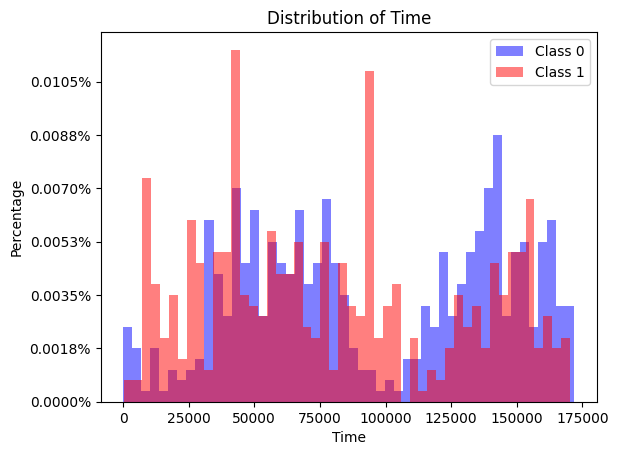

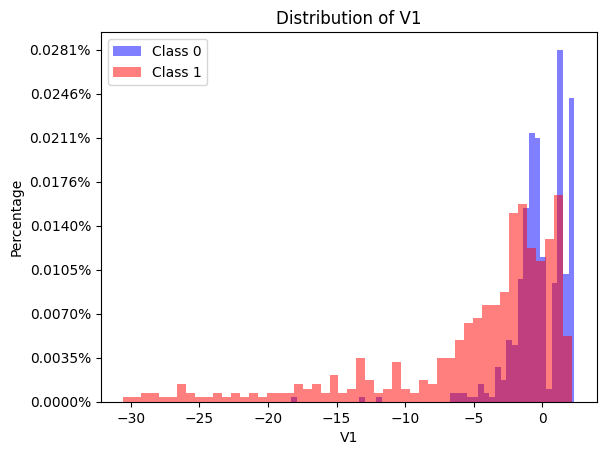

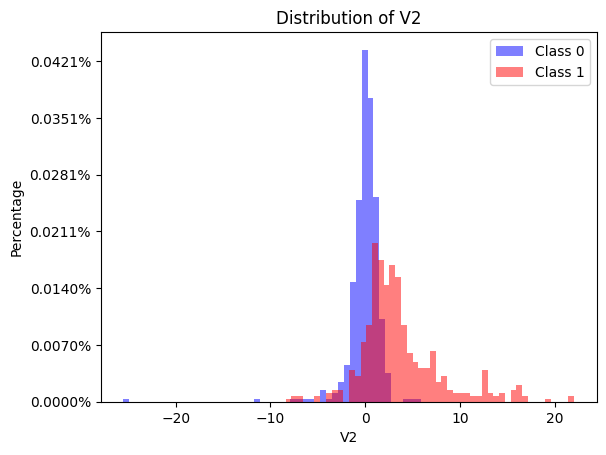

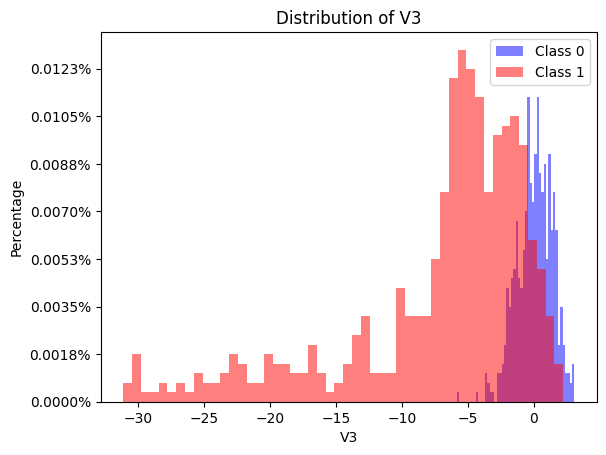

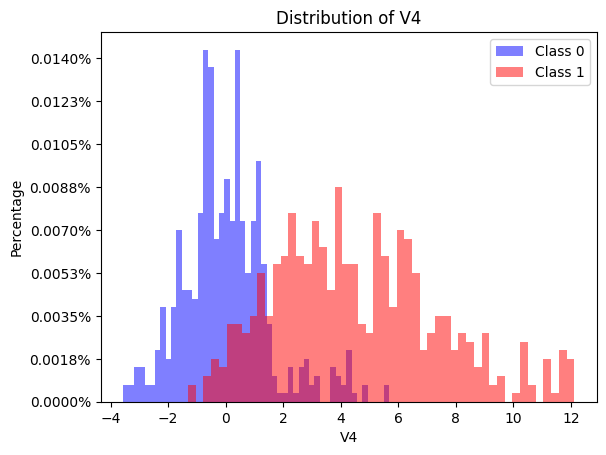

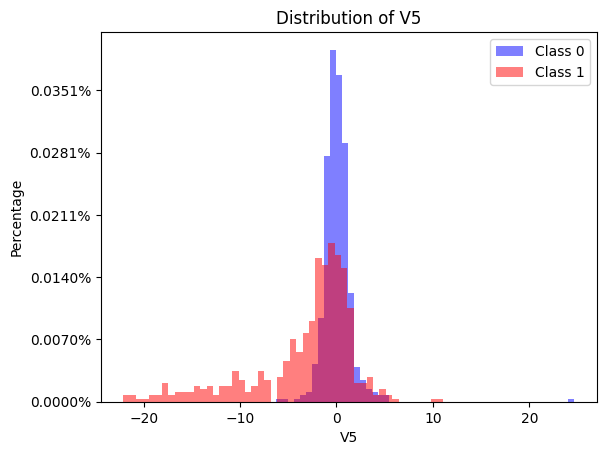

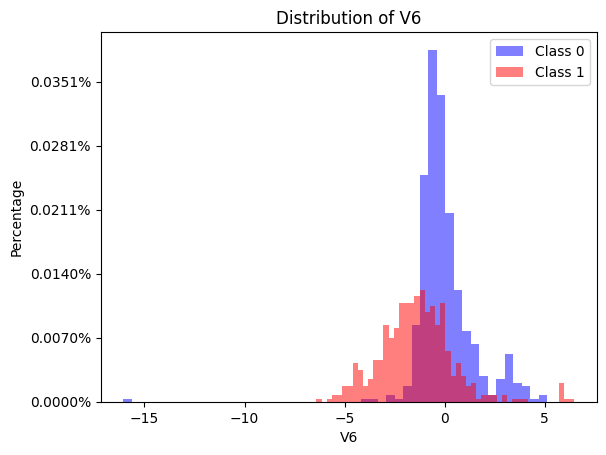

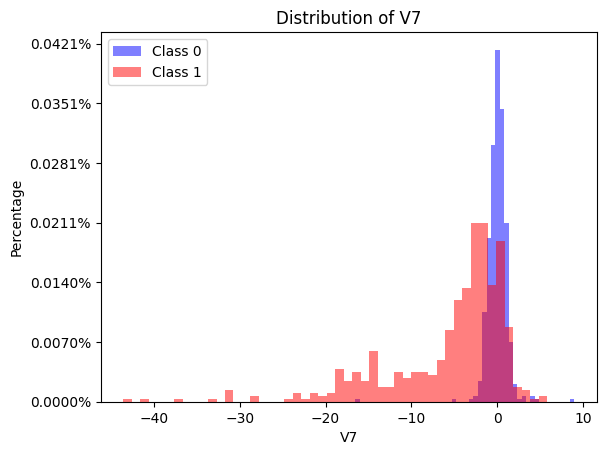

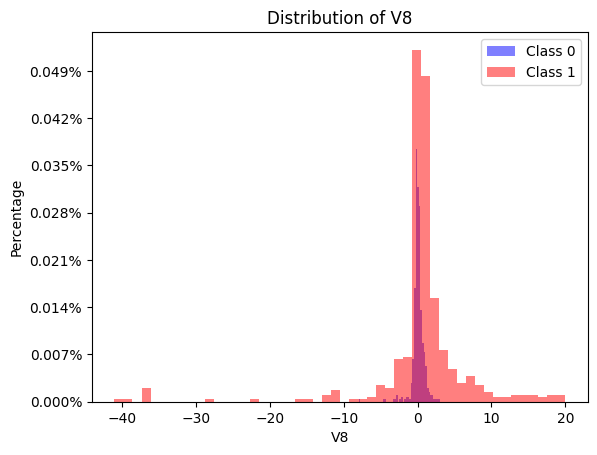

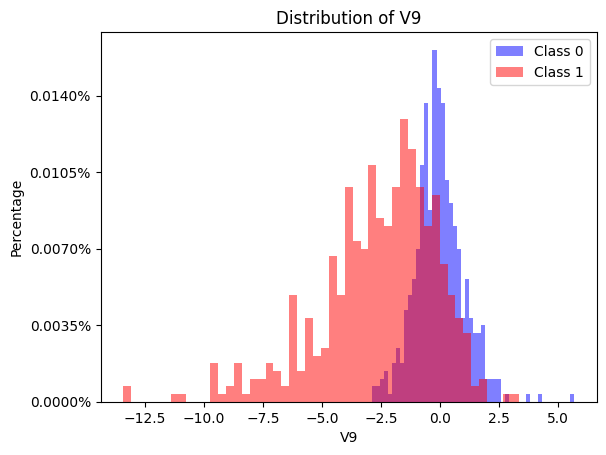

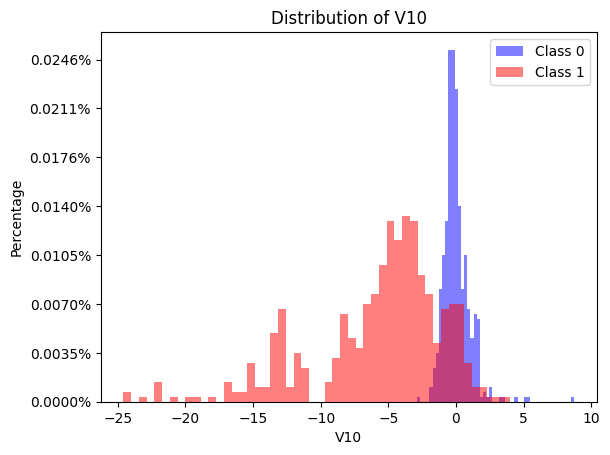

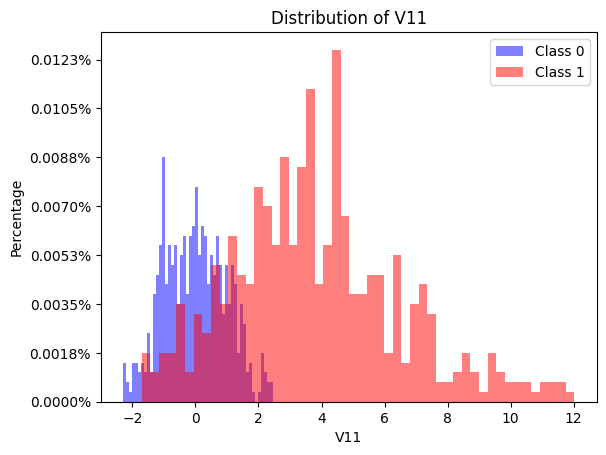

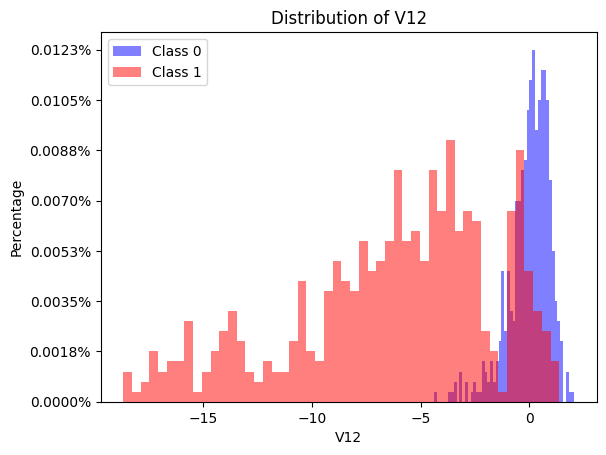

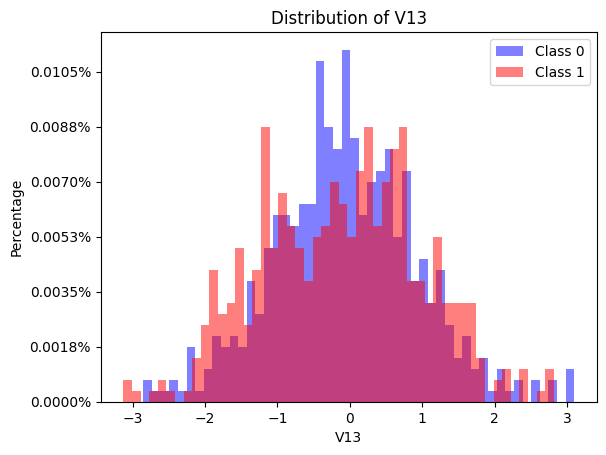

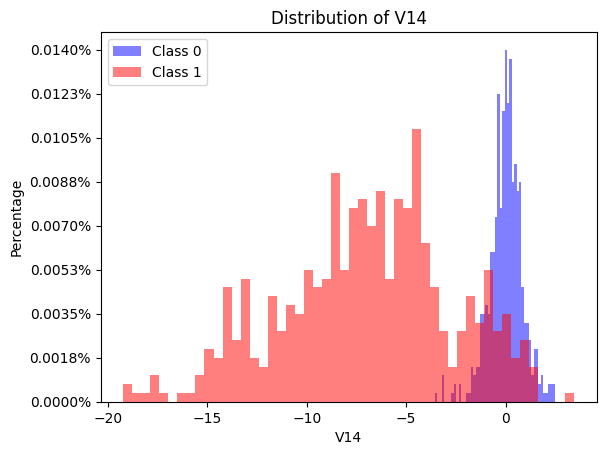

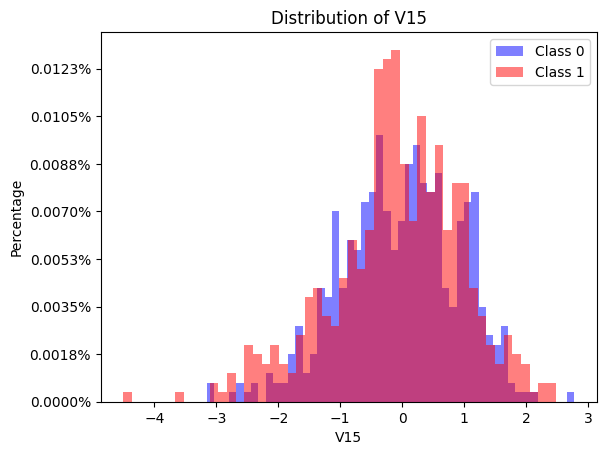

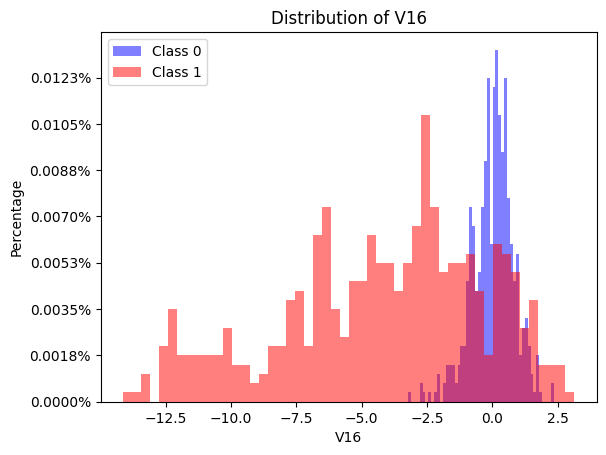

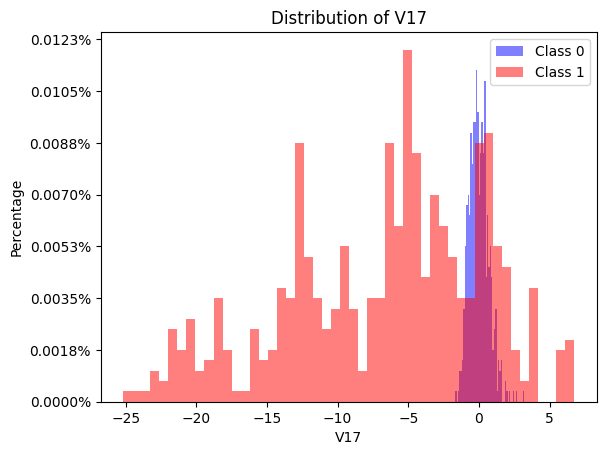

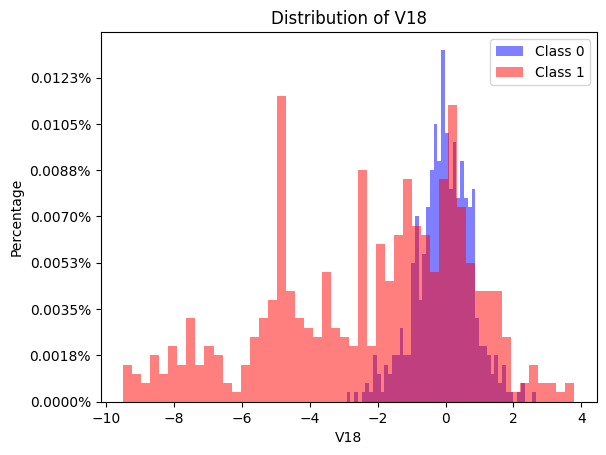

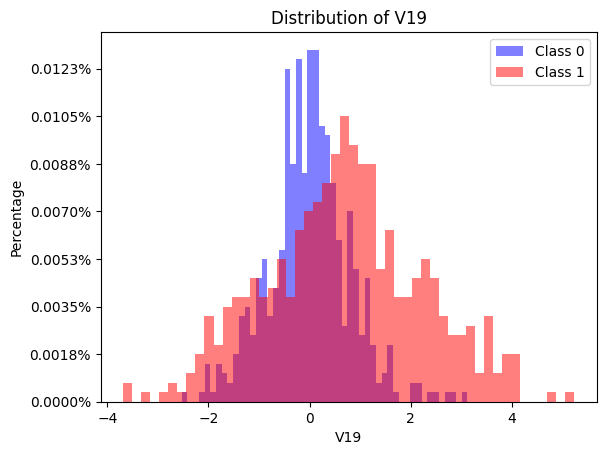

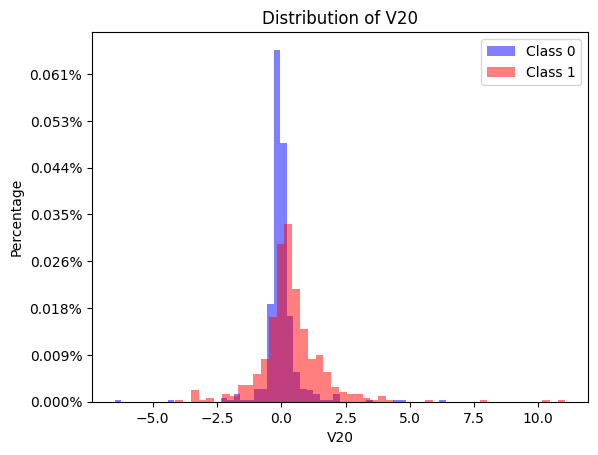

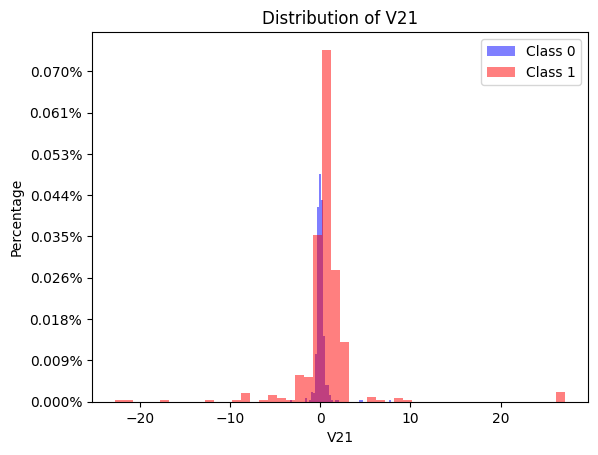

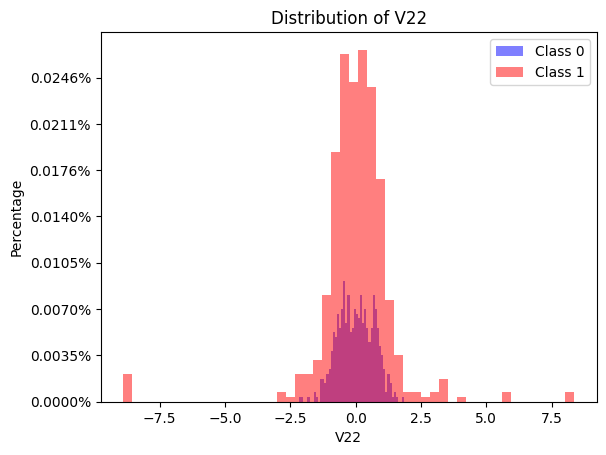

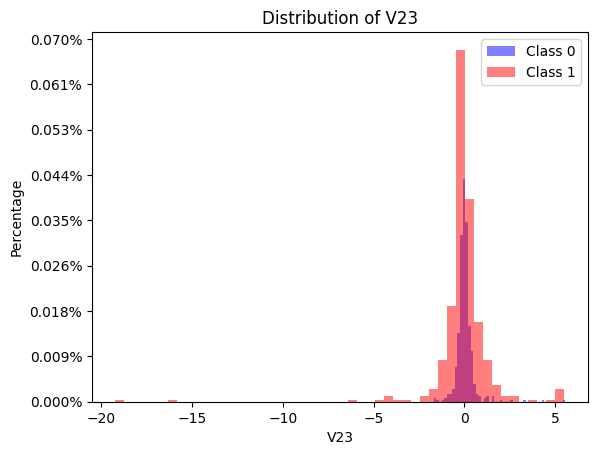

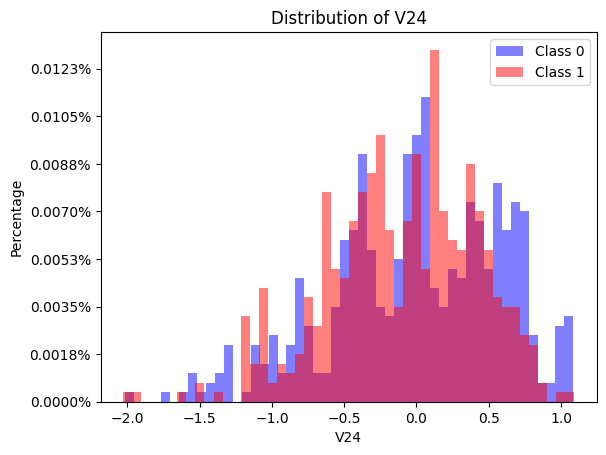

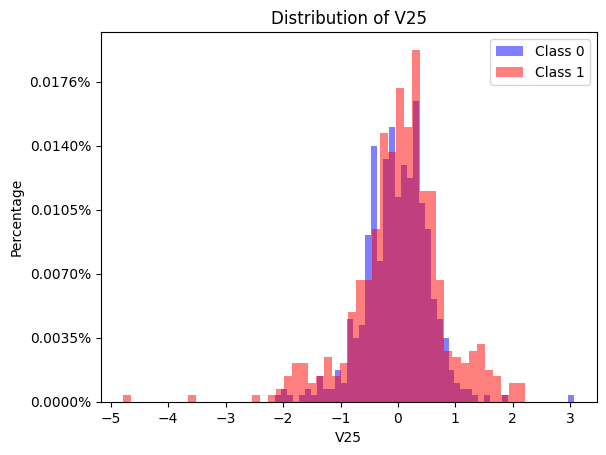

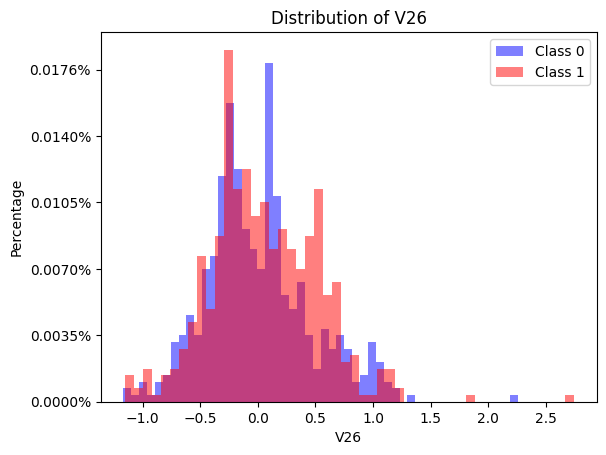

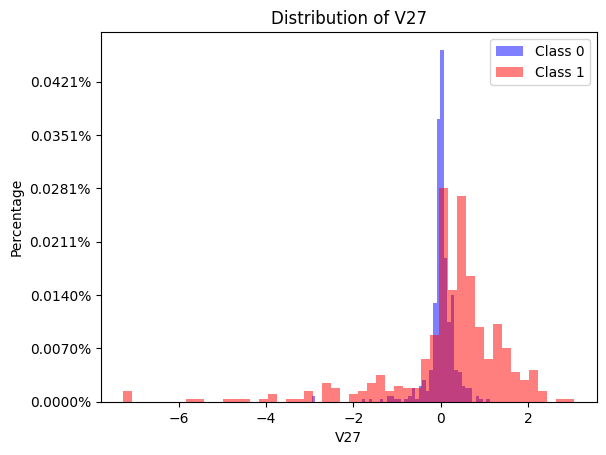

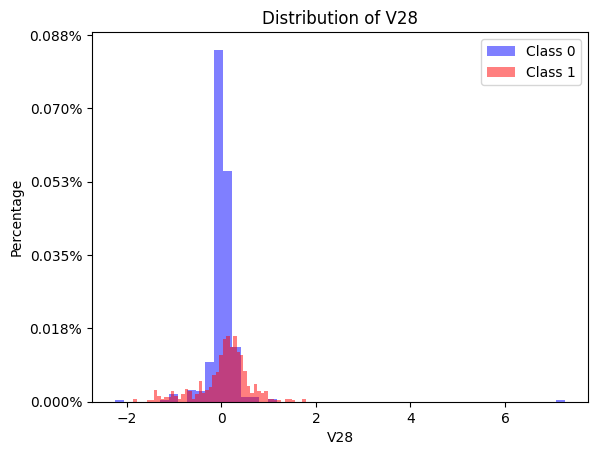

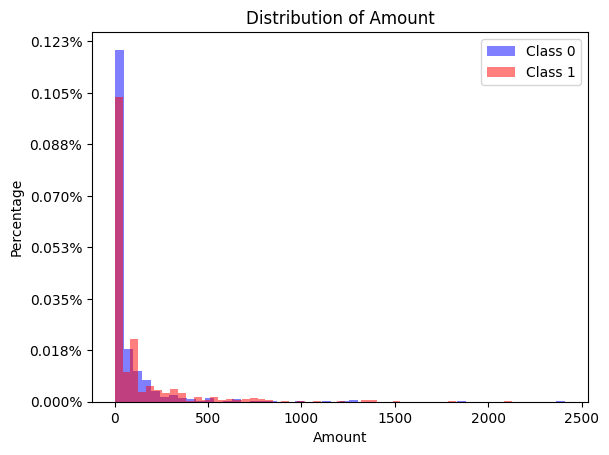

In [24]:
# 特征可视化

import modin.pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# 读取CSV文件
data = pd.read_csv("creditcard.csv")


# 切分特征和标签
X = data.loc[:, data.columns != 'Class']
y = data.loc[:, data.columns == 'Class']
# print(X)
# print(y)
 
# 下采样，使得两个样本同样少
# Number of data points in the minority class
number_records_fraud = len(data[data.Class == 1])# 计算异常样本的个数
fraud_indices = np.array(data[data.Class == 1].index) # 异常样本在原数据的索引值
 
# Picking the indices of the normal classes
normal_indices = data[data.Class == 0].index # 获得原数据正常样本的索引值
 
# Out of the indices we picked, randomly select "x" number (number_records_fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False) # 通过索引进行随机的选择
random_normal_indices = np.array(random_normal_indices)
 
# Appending the 2 indices
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices]) # 将class=1和class=0 的选出来的索引值进行合并
 
# Under sample dataset
under_sample_data = data.iloc[under_sample_indices,:]
 
X_undersample = under_sample_data.loc[:, under_sample_data.columns != 'Class']
y_undersample = under_sample_data.loc[:, under_sample_data.columns == 'Class']


# 分割两类数据
class_0 = under_sample_data[under_sample_data["Class"] == 0]
class_1 = under_sample_data[under_sample_data["Class"] == 1]

# 提取特征列
features = data.columns[:-1]  # 最后一列是标签列

# 绘制特征分布图
for feature in features:
    plt.figure()
    plt.hist(class_0[feature], bins=50, color='blue', alpha=0.5, label='Class 0')
    plt.hist(class_1[feature], bins=50, color='red', alpha=0.5, label='Class 1')
    plt.xlabel(feature)
    plt.ylabel('Percentage')
    plt.title(f'Distribution of {feature}')
    plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=len(data)))
    plt.legend()
    plt.show()

（编一下数据取舍的原因）

在将特征取舍之后，对各个特征进行重要性分析

In [25]:
# 特征重要性分析

import modin.pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# 读取CSV文件
data = pd.read_csv("creditcard.csv")

# 下采样，使得两个样本同样少
# Number of data points in the minority class
number_records_fraud = len(data[data.Class == 1])# 计算异常样本的个数
fraud_indices = np.array(data[data.Class == 1].index) # 异常样本在原数据的索引值
 
# Picking the indices of the normal classes
normal_indices = data[data.Class == 0].index # 获得原数据正常样本的索引值
 
# Out of the indices we picked, randomly select "x" number (number_records_fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False) # 通过索引进行随机的选择
random_normal_indices = np.array(random_normal_indices)
 
# Appending the 2 indices
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices]) # 将class=1和class=0 的选出来的索引值进行合并
 
# Under sample dataset
under_sample_data = data.iloc[under_sample_indices,:]

# 观察特征可视化后选择剔除部分特征
droplist = ['V8', 'V13', 'V15', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Time']
data_new = under_sample_data.drop(droplist, axis=1)

x = data_new.iloc[:, data_new.columns != 'Class']
y = data_new.iloc[:, data_new.columns == 'Class']
clf = RandomForestClassifier(n_estimators=10, random_state=123, max_depth=4)
clf.fit(x, y)
for feature in zip(x, clf.feature_importances_):
    print(feature)

('V1', 0.01056669005837494)
('V2', 0.0052666321286282385)
('V3', 0.0153025949988793)
('V4', 0.11012992676905237)
('V5', 0.0010851653420859047)
('V6', 0.0010185252288839072)
('V7', 0.007864643733612014)
('V9', 0.008904614961721099)
('V10', 0.2684997613392739)
('V11', 0.1506136032398354)
('V12', 0.09559242065936503)
('V14', 0.2049373566531272)
('V16', 0.0035111573793707106)
('V17', 0.09693391466513987)
('V18', 0.0026668750141985637)
('V19', 0.003544327682767259)
('Amount', 0.013561790145684418)


之后我们采用两种思路建立模型，一种是传统的机器学习方法，另一种是深度神经网络。

首先，我们对数据分别应用传统的机器学习方法。

In [39]:
from sklearnex import patch_sklearn
patch_sklearn()

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

# 读取CSV文件
data = pd.read_csv("creditcard.csv")

# 下采样，使得两个样本同样少
# Number of data points in the minority class
number_records_fraud = len(data[data.Class == 1])  # 计算异常样本的个数
fraud_indices = np.array(data[data.Class == 1].index)  # 异常样本在原数据的索引值

# Picking the indices of the normal classes
normal_indices = data[data.Class == 0].index  # 获得原数据正常样本的索引值

# Out of the indices we picked, randomly select "x" number (number_records_fraud)
random_normal_indices = np.random.choice(
    normal_indices, number_records_fraud, replace=False
)  # 通过索引进行随机的选择
random_normal_indices = np.array(random_normal_indices)

# Appending the 2 indices
under_sample_indices = np.concatenate(
    [fraud_indices, random_normal_indices]
)  # 将class=1和class=0 的选出来的索引值进行合并

# Under sample dataset
under_sample_data = data.iloc[under_sample_indices, :]

# 观察特征可视化后选择剔除部分特征
droplist = [
    "V8",
    "V13",
    "V15",
    "V20",
    "V21",
    "V22",
    "V23",
    "V24",
    "V25",
    "V26",
    "V27",
    "V28",
    "Time",
]
data_new = under_sample_data.drop(droplist, axis=1)

# 切分训练集和测试集
X = data_new.iloc[:, data_new.columns != "Class"]
y = data_new.iloc[:, data_new.columns == "Class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 建立模型

# 1. 决策树
tree_model = DecisionTreeClassifier(max_depth=4, criterion="entropy")
tree_model.fit(X_train, y_train)
tree_yhat = tree_model.predict(X_test)


# 2. k最近邻居
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn_yhat = knn.predict(X_test)


# 3. 逻辑斯蒂回归
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_yhat = lr.predict(X_test)


# 4. 支持向量机
svm = SVC()
svm.fit(X_train, y_train)
svm_yhat = svm.predict(X_test)


# 5. 随机森林
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
rf_yhat = rf.predict(X_test)


# 6. XGBoost
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgb_yhat = xgb.predict(X_test)

print(f"tree accuracy: {accuracy_score(y_test, tree_yhat)}")
print(f"knn accuracy: {accuracy_score(y_test, knn_yhat)}")
print(f"lr accuracy: {accuracy_score(y_test, lr_yhat)}")
print(f"svm accuracy: {accuracy_score(y_test, svm_yhat)}")
print(f"rf accuracy: {accuracy_score(y_test, rf_yhat)}")
print(f"xgb accuracy: {accuracy_score(y_test, xgb_yhat)}")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
INFO:sklearnex: sklearn.model_selection.train_test_split: running accelerated version on CPU
2023-11-26 13:13:49,579 - sklearnex - INFO - sklearn.model_selection.train_test_split: running accelerated version on CPU
INFO:sklearnex: sklearn.model_selection.train_test_split: running accelerated version on CPU
2023-11-26 13:13:49,581 - sklearnex - INFO - sklearn.model_selection.train_test_split: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.fit: running accelerated version on CPU
2023-11-26 13:13:49,599 - sklearnex - INFO - sklearn.neighbors.KNeighborsClassifier.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict: running accelerated version on CPU
2023-11-26 13:13:49,606 - sklearnex - INFO - sklearn.neighbors.KNeighborsClassifier.predict: running accelerated version on CPU
STOP: TOTAL NO. of ITERATIONS R

tree accuracy: 0.9390862944162437
knn accuracy: 0.9289340101522843
lr accuracy: 0.9543147208121827
svm accuracy: 0.8477157360406091
rf accuracy: 0.9593908629441624
xgb accuracy: 0.9695431472081218


（这结果需要吹还是贬低下？）

之后我们应用深度神经网络

In [38]:
import pandas as pd
import numpy as np
from utils.args import parser
from utils.dataset import CreditCardDataset, splitter, decimation
from utils.model import Classifier
from training.dl import train_dl, predict


args = parser.parse_known_args()[0]

if args.decimation:
    decimation()
    data = pd.read_csv("creditcard-decimation.csv")
else:
    data = pd.read_csv("creditcard.csv")

if args.method == "dl":

    full_dataset = CreditCardDataset(data)
    train_dataset, test_dataset = splitter(full_dataset, args.split)
    input_size = len(full_dataset.features)
    model = Classifier(input_size=input_size)

    best_loss = train_dl(
        model=model,
        device=args.device,
        train_dataset=train_dataset,
        epochs=args.epochs,
        batch_size=args.batch_size,
        lr=args.lr,
        output_path=args.output_path,
        use_ipex=args.ipex,
    )

    accuracy = predict(
        model=model,
        device=args.device,
        test_dataset=test_dataset,
        batch_size=args.batch_size,
        output_path=args.output_path,
        use_ipex=args.ipex,
    )
    print(f"Best loss: {best_loss}, Accuracy: {accuracy}")

正使用ipex加速训练🚀


Training: 100%|██████████| 500/500 [02:26<00:00,  3.42it/s]


正使用ipex加速推理🚀
Best loss: 8.74200850375928e-07, Accuracy: 0.949238578680203


（吹下结果）